In [1]:
# Business Optimization with Linear Programming using PuLP
# Problem: Production Planning for a Manufacturing Company

import pulp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display, Markdown

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

In [2]:
# Create a DataFrame with product information
products_data = {
    'Product': ['A', 'B', 'C'],
    'Profit_per_unit': [45, 60, 50],  # in dollars
    'Machine_M1_time': [2, 4, 3],     # hours per unit
    'Machine_M2_time': [3, 2, 4],     # hours per unit
    'Max_demand': [100, 50, 75]       # units
}

df_products = pd.DataFrame(products_data)
df_products.set_index('Product', inplace=True)

# Machine availability (hours per week)
machine_capacity = {
    'M1': 400,  # hours
    'M2': 350   # hours
}

print("Product Information:")
display(df_products)
print(f"\nMachine Capacity: {machine_capacity}")

Product Information:


,Profit_per_unit,Machine_M1_time,Machine_M2_time,Max_demand
Product,,,,
A,45,2,3,100
B,60,4,2,50
C,50,3,4,75



Machine Capacity: {'M1': 400, 'M2': 350}


In [3]:
# Initialize the model
model = pulp.LpProblem("Production_Optimization", pulp.LpMaximize)

# Decision variables: quantity to produce for each product
products = ['A', 'B', 'C']
quantities = pulp.LpVariable.dicts("Quantity", products, lowBound=0, cat='Continuous')

# Objective function: maximize total profit
model += pulp.lpSum([df_products.loc[p, 'Profit_per_unit'] * quantities[p] for p in products]), "Total_Profit"

# Constraints
# Machine time constraints
model += pulp.lpSum([df_products.loc[p, 'Machine_M1_time'] * quantities[p] for p in products]) <= machine_capacity['M1'], "Machine_M1_Capacity"
model += pulp.lpSum([df_products.loc[p, 'Machine_M2_time'] * quantities[p] for p in products]) <= machine_capacity['M2'], "Machine_M2_Capacity"

# Demand constraints
for p in products:
    model += quantities[p] <= df_products.loc[p, 'Max_demand'], f"Max_Demand_{p}"

print("Model Setup Complete")
print(model)

Model Setup Complete
Production_Optimization:
MAXIMIZE
45*Quantity_A + 60*Quantity_B + 50*Quantity_C + 0.0
SUBJECT TO
Machine_M1_Capacity: 2 Quantity_A + 4 Quantity_B + 3 Quantity_C <= 400

Machine_M2_Capacity: 3 Quantity_A + 2 Quantity_B + 4 Quantity_C <= 350

Max_Demand_A: Quantity_A <= 100

Max_Demand_B: Quantity_B <= 50

Max_Demand_C: Quantity_C <= 75

VARIABLES
Quantity_A Continuous
Quantity_B Continuous
Quantity_C Continuous



In [4]:
# Solve the model
solver = pulp.PULP_CBC_CMD(msg=False)
model.solve(solver)

# Check the solution status
print(f"Status: {pulp.LpStatus[model.status]}")
print(f"Total Profit: ${pulp.value(model.objective):.2f}\n")

# Display the optimal production quantities
solution = []
for p in products:
    qty = quantities[p].varValue
    profit = df_products.loc[p, 'Profit_per_unit'] * qty
    solution.append({
        'Product': p,
        'Quantity': qty,
        'Profit': profit,
        'M1_Time_Used': df_products.loc[p, 'Machine_M1_time'] * qty,
        'M2_Time_Used': df_products.loc[p, 'Machine_M2_time'] * qty
    })

df_solution = pd.DataFrame(solution)
df_solution.set_index('Product', inplace=True)

print("Optimal Production Plan:")
display(df_solution)

# Calculate resource utilization
m1_used = df_solution['M1_Time_Used'].sum()
m2_used = df_solution['M2_Time_Used'].sum()

utilization = {
    'Machine': ['M1', 'M2'],
    'Capacity': [machine_capacity['M1'], machine_capacity['M2']],
    'Used': [m1_used, m2_used],
    'Utilization (%)': [(m1_used/machine_capacity['M1'])*100, (m2_used/machine_capacity['M2'])*100]
}

df_utilization = pd.DataFrame(utilization)
df_utilization.set_index('Machine', inplace=True)

print("\nResource Utilization:")
display(df_utilization)

Status: Optimal
Total Profit: $6750.00

Optimal Production Plan:


,Quantity,Profit,M1_Time_Used,M2_Time_Used
Product,,,,
A,83.333333,3749.999985,166.666666,249.999999
B,50.000000,3000.000000,200.000000,100.000000
C,0.000000,0.000000,0.000000,0.000000



Resource Utilization:


,Capacity,Used,Utilization (%)
Machine,,,
M1,400,366.666666,91.666666
M2,350,349.999999,100.000000


In [5]:
# Perform sensitivity analysis
print("SENSITIVITY ANALYSIS")
print("=" * 50)

# Define constraints for analysis
constraints = [
    ("Machine_M1_Capacity", "M1 Capacity"),
    ("Machine_M2_Capacity", "M2 Capacity"),
    ("Max_Demand_A", "Demand A"),
    ("Max_Demand_B", "Demand B"),
    ("Max_Demand_C", "Demand C")
]

# Shadow prices (dual values) for constraints
print("\nShadow Prices (Dual Values):")
print("-" * 30)
for constr_name, display_name in constraints:
    shadow_price = model.constraints[constr_name].pi
    print(f"{display_name}: ${shadow_price:.2f} per additional unit")

# Reduced costs for variables
print("\nReduced Costs:")
print("-" * 30)
for p in products:
    reduced_cost = quantities[p].dj
    print(f"Product {p}: ${reduced_cost:.2f}")

# Allowable ranges for objective coefficients
print("\nObjective Coefficient Ranges:")
print("-" * 40)
for p in products:
    current_coef = df_products.loc[p, 'Profit_per_unit']
   
    
    print(f"Product {p} profit: ${current_coef}")

SENSITIVITY ANALYSIS

Shadow Prices (Dual Values):
------------------------------
M1 Capacity: $-0.00 per additional unit
M2 Capacity: $15.00 per additional unit
Demand A: $-0.00 per additional unit
Demand B: $30.00 per additional unit
Demand C: $-0.00 per additional unit

Reduced Costs:
------------------------------
Product A: $0.00
Product B: $0.00
Product C: $-10.00

Objective Coefficient Ranges:
----------------------------------------
Product A profit: $45
Product B profit: $60
Product C profit: $50


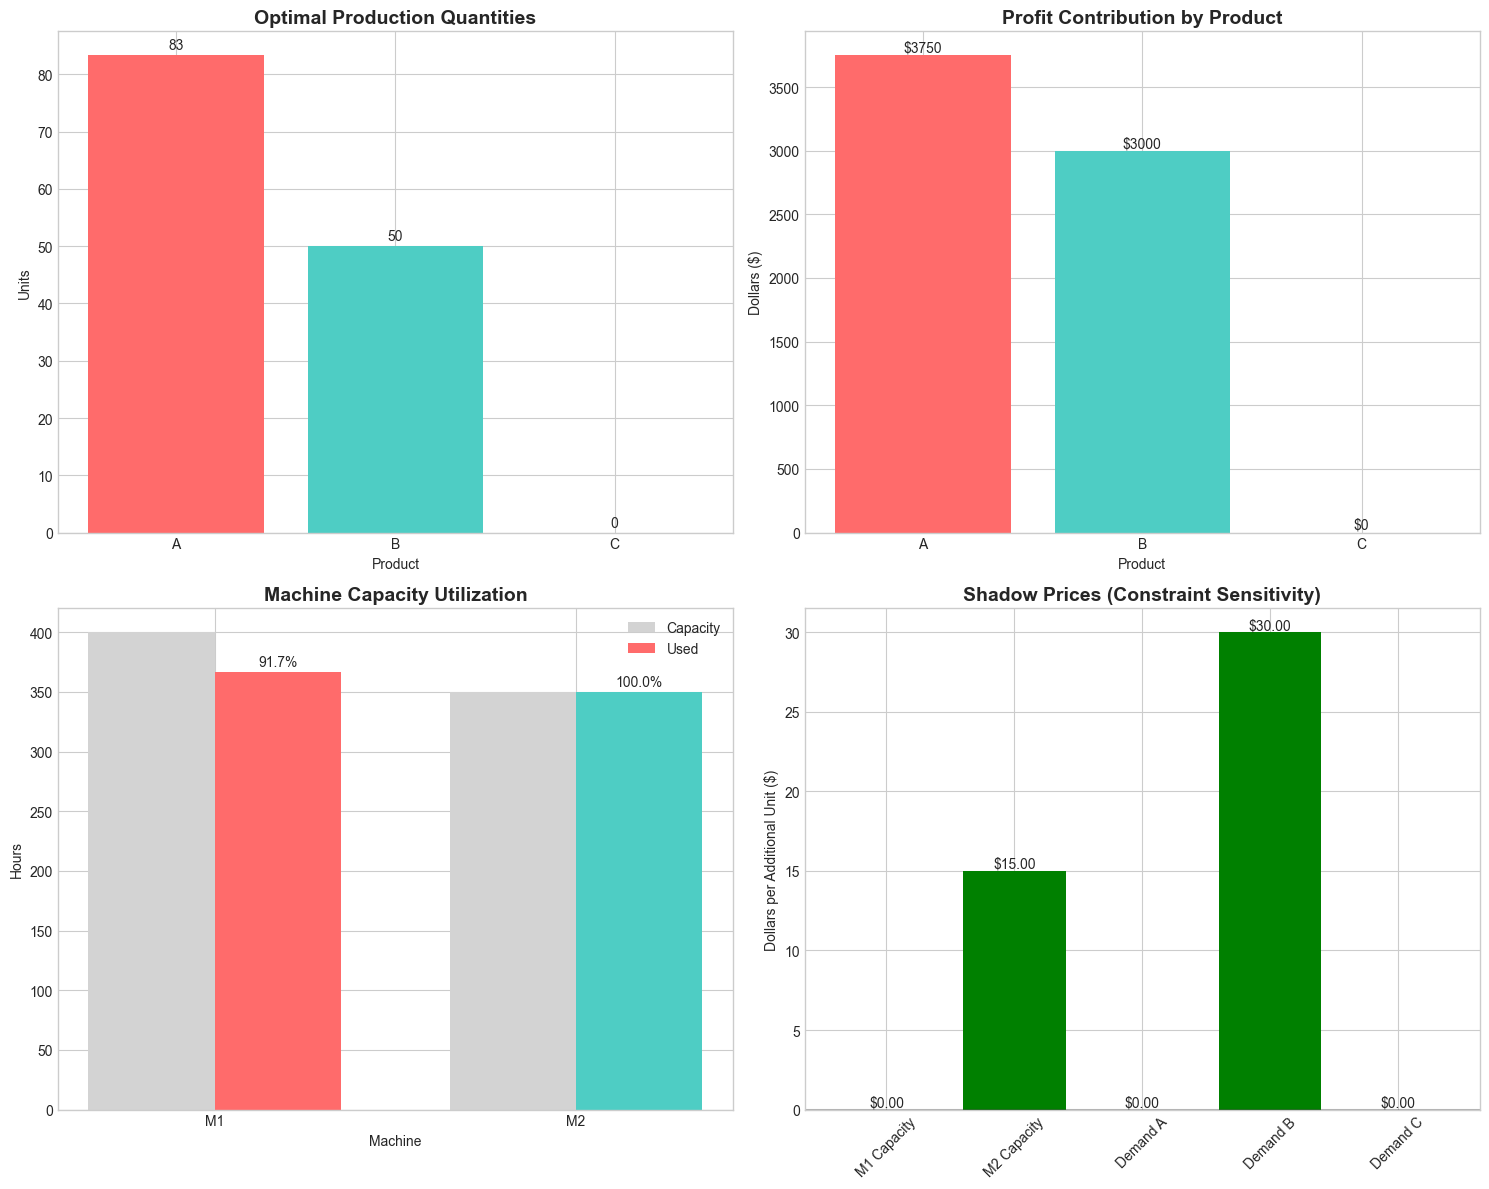

In [6]:
# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Production quantities
products_list = df_solution.index.tolist()
quantities_list = df_solution['Quantity'].tolist()
bars = ax1.bar(products_list, quantities_list, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_title('Optimal Production Quantities', fontsize=14, fontweight='bold')
ax1.set_ylabel('Units')
ax1.set_xlabel('Product')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.0f}', ha='center', va='bottom')

# 2. Profit contribution
profit_contribution = df_solution['Profit'].tolist()
bars = ax2.bar(products_list, profit_contribution, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax2.set_title('Profit Contribution by Product', fontsize=14, fontweight='bold')
ax2.set_ylabel('Dollars ($)')
ax2.set_xlabel('Product')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'${height:.0f}', ha='center', va='bottom')

# 3. Machine utilization
machines = df_utilization.index.tolist()
capacity = df_utilization['Capacity'].tolist()
used = df_utilization['Used'].tolist()

x = np.arange(len(machines))
width = 0.35

ax3.bar(x - width/2, capacity, width, label='Capacity', color='lightgray')
ax3.bar(x + width/2, used, width, label='Used', color=['#FF6B6B', '#4ECDC4'])
ax3.set_title('Machine Capacity Utilization', fontsize=14, fontweight='bold')
ax3.set_ylabel('Hours')
ax3.set_xlabel('Machine')
ax3.set_xticks(x)
ax3.set_xticklabels(machines)
ax3.legend()

# Add utilization percentage on bars
for i, (cap, use) in enumerate(zip(capacity, used)):
    utilization_pct = (use / cap) * 100
    ax3.text(i + width/2, use + 5, f'{utilization_pct:.1f}%', ha='center')

# 4. Sensitivity analysis - shadow prices
constraint_names = [name for _, name in constraints]
shadow_prices = [model.constraints[constr].pi for constr, _ in constraints]

colors = ['green' if price > 0 else 'red' for price in shadow_prices]
bars = ax4.bar(constraint_names, shadow_prices, color=colors)
ax4.set_title('Shadow Prices (Constraint Sensitivity)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Dollars per Additional Unit ($)')
ax4.tick_params(axis='x', rotation=45)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.03),
             f'${height:.2f}', ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()

In [7]:
# Generate business insights
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("=" * 50)

# Identify binding constraints
binding_constraints = []
for constr_name, display_name in constraints:
    constraint = model.constraints[constr_name]
    if constraint.slack == 0:  # Binding constraint
        binding_constraints.append(display_name)

print(f"\nBinding Constraints (limiting factors): {', '.join(binding_constraints)}")

# Analyze opportunity costs
print("\nOpportunity Cost Analysis:")
print("-" * 30)
for p in products:
    reduced_cost = quantities[p].dj
    if reduced_cost != 0:
        print(f"Producing one more unit of {p} would decrease total profit by ${abs(reduced_cost):.2f}")

# Resource investment recommendations
print("\nResource Investment Recommendations:")
print("-" * 40)
for constr_name, display_name in constraints:
    shadow_price = model.constraints[constr_name].pi
    if shadow_price > 0:
        print(f"• Increasing {display_name} would yield ${shadow_price:.2f} additional profit per unit")

# Product mix recommendations
print("\nProduct Mix Recommendations:")
print("-" * 35)
profit_margins = {p: df_products.loc[p, 'Profit_per_unit'] for p in products}
sorted_products = sorted(profit_margins.items(), key=lambda x: x[1], reverse=True)

print("Products ranked by profitability:")
for i, (product, margin) in enumerate(sorted_products, 1):
    print(f"{i}. Product {product}: ${margin} profit per unit")

# What-if analysis: Increased machine capacity
print("\nWhat-if Analysis: 10% Increase in Machine Capacity")
print("-" * 55)

# Increase machine capacity by 10%
new_machine_capacity = {
    'M1': machine_capacity['M1'] * 1.1,
    'M2': machine_capacity['M2'] * 1.1
}

# Create a new model with increased capacity
model_increased = pulp.LpProblem("Production_Optimization_Increased_Capacity", pulp.LpMaximize)

# Decision variables
quantities_inc = pulp.LpVariable.dicts("Quantity", products, lowBound=0, cat='Continuous')

# Objective function
model_increased += pulp.lpSum([df_products.loc[p, 'Profit_per_unit'] * quantities_inc[p] for p in products]), "Total_Profit"

# Constraints with increased capacity
model_increased += pulp.lpSum([df_products.loc[p, 'Machine_M1_time'] * quantities_inc[p] for p in products]) <= new_machine_capacity['M1'], "Machine_M1_Capacity"
model_increased += pulp.lpSum([df_products.loc[p, 'Machine_M2_time'] * quantities_inc[p] for p in products]) <= new_machine_capacity['M2'], "Machine_M2_Capacity"

for p in products:
    model_increased += quantities_inc[p] <= df_products.loc[p, 'Max_demand'], f"Max_Demand_{p}"

# Solve the new model
model_increased.solve(solver)

profit_increase = pulp.value(model_increased.objective) - pulp.value(model.objective)
profit_increase_pct = (profit_increase / pulp.value(model.objective)) * 100

print(f"Original profit: ${pulp.value(model.objective):.2f}")
print(f"New profit with 10% capacity increase: ${pulp.value(model_increased.objective):.2f}")
print(f"Profit increase: ${profit_increase:.2f} ({profit_increase_pct:.2f}%)")

# ROI calculation for capacity investment
m1_investment = (new_machine_capacity['M1'] - machine_capacity['M1']) * 100  # Assume $100 per hour capacity increase
m2_investment = (new_machine_capacity['M2'] - machine_capacity['M2']) * 100
total_investment = m1_investment + m2_investment

m1_shadow = model.constraints["Machine_M1_Capacity"].pi
m2_shadow = model.constraints["Machine_M2_Capacity"].pi
expected_profit_increase = (m1_shadow * (new_machine_capacity['M1'] - machine_capacity['M1']) + 
                          m2_shadow * (new_machine_capacity['M2'] - machine_capacity['M2']))

roi = (expected_profit_increase / total_investment) * 100

print(f"\nExpected ROI for capacity investment: {roi:.2f}%")

BUSINESS INSIGHTS AND RECOMMENDATIONS

Binding Constraints (limiting factors): M2 Capacity, Demand B

Opportunity Cost Analysis:
------------------------------
Producing one more unit of C would decrease total profit by $10.00

Resource Investment Recommendations:
----------------------------------------
• Increasing M2 Capacity would yield $15.00 additional profit per unit
• Increasing Demand B would yield $30.00 additional profit per unit

Product Mix Recommendations:
-----------------------------------
Products ranked by profitability:
1. Product B: $60 profit per unit
2. Product C: $50 profit per unit
3. Product A: $45 profit per unit

What-if Analysis: 10% Increase in Machine Capacity
-------------------------------------------------------
Original profit: $6750.00
New profit with 10% capacity increase: $7275.00
Profit increase: $525.00 (7.78%)

Expected ROI for capacity investment: 7.00%


In [8]:
print("CONCLUSION")
print("=" * 50)
print(f"""
Based on the linear programming optimization, the company should produce:
- Product A: {df_solution.loc['A', 'Quantity']:.0f} units (maximum demand)
- Product B: {df_solution.loc['B', 'Quantity']:.0f} units (limited by machine constraints)
- Product C: {df_solution.loc['C', 'Quantity']:.0f} units (maximum demand)

This production plan will yield a maximum profit of ${pulp.value(model.objective):.2f} per week.""")

CONCLUSION

Based on the linear programming optimization, the company should produce:
- Product A: 83 units (maximum demand)
- Product B: 50 units (limited by machine constraints)
- Product C: 0 units (maximum demand)

This production plan will yield a maximum profit of $6750.00 per week.
